In [145]:
### run with pync_environment.yml (TCRE_land_bayes) that is provided in the repo

import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pytensor as pt
import pdfplumber
import xarray as xr
sns.set_style("whitegrid")

### Read beta and gamma estimates

In [146]:
TCREsource_betagamma = pd.read_csv('output/TCREsource_betagamma.csv')
TCREsource_betagamma

,model,source,beta_L_4xCO2,gamma_L_4xCO2,beta_L_2xCO2,gamma_L_2xCO2
0,ACCESS-ESM1-5,CMIP6,0.333088,-19.757934,0.678184,-9.773156
1,BCC-CSM2-MR,CMIP6,1.424187,-149.698700,1.718358,-88.570843
2,CanESM5,CMIP6,1.295088,17.067448,1.417113,-5.086536
3,CESM2,CMIP6,0.892947,-20.473513,0.969559,-12.235524
4,CNRM-ESM2-1,CMIP6,1.355567,-85.340904,1.366551,-51.900089
5,GFDL-ESM4,CMIP6,0.909425,-71.340154,1.069121,-47.313396
6,IPSL-CM6A-LR,CMIP6,0.547614,-3.701619,0.942895,-7.884895
7,MIROC-ES2L,CMIP6,1.095826,-66.797503,1.398632,-55.103245
8,MPI-ESM1-2-LR,CMIP6,0.706874,-4.834828,1.064026,-0.272097
9,NorESM2-LM,CMIP6,0.839742,-22.048617,0.940883,-17.159239


In [147]:
beta_4xCO2 = TCREsource_betagamma['beta_L_4xCO2'].values
gamma_4xCO2 = TCREsource_betagamma['gamma_L_4xCO2'].values
beta_2xCO2 = TCREsource_betagamma['beta_L_2xCO2'].values
gamma_2xCO2 = TCREsource_betagamma['gamma_L_2xCO2'].values

beta_4xCO2_cmip6 = beta_4xCO2[TCREsource_betagamma['source'].isin(['CMIP6', 'CMIP6+'])]
gamma_4xCO2_cmip6 = gamma_4xCO2[TCREsource_betagamma['source'].isin(['CMIP6', 'CMIP6+'])]

In [148]:
evidence_CMIP6={}
evidence_CMIP6['beta_land']=beta_4xCO2_cmip6
evidence_CMIP6['gamma_land']=gamma_4xCO2_cmip6

In [149]:
# process grouping
cmip6_models = np.array(['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-ESM2-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL', 'EC-Earth3-CC', 'CMCC-ESM2'])

cmip6_hasNitro = np.array([True, False, False, True, False, False, False, True, True, True, True, True, True])
cmip6_hasPF = np.array([False, False, False, True, False, False, False, False, False, True, False, False, True])
cmip6_hasFire = np.array([False, False, False, True, True, True, False, False, True, True, False, True, True])
cmip6_hasDynveg = np.array([False, False, False, False, False, True, False, False, True, False, True, True, False])

<Axes: title={'center': 'γ${_L}$ CMIP6 models'}, xlabel='γ${_L}$ (PgC/°C)', ylabel='Density'>

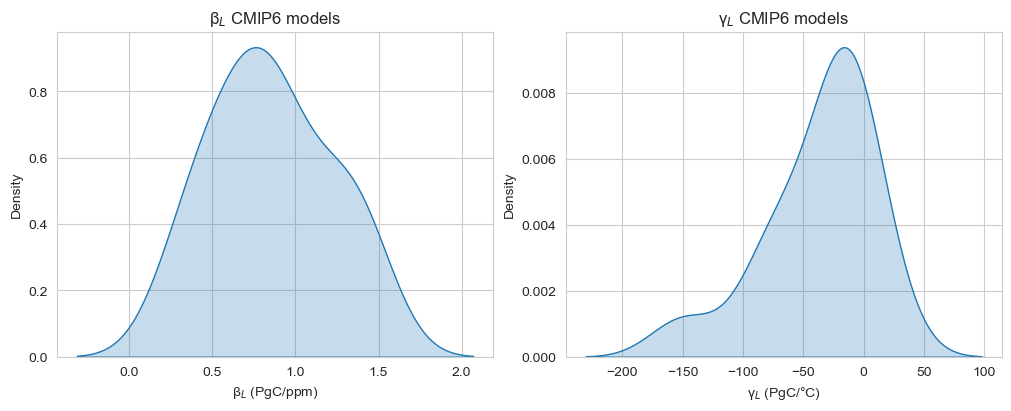

In [150]:
fig = plt.figure(figsize=(10,4), layout="constrained")

sub = fig.add_subplot(1, 2, 1)
plt.title('β${_L}$ CMIP6 models')
sub.set_xlabel('β${_L}$ (PgC/ppm)')
sns.kdeplot(evidence_CMIP6['beta_land'], fill=True)

sub = fig.add_subplot(1, 2, 2)
plt.title('γ${_L}$ CMIP6 models')
sub.set_xlabel('γ${_L}$ (PgC/°C)')
sns.kdeplot(evidence_CMIP6['gamma_land'], fill=True)


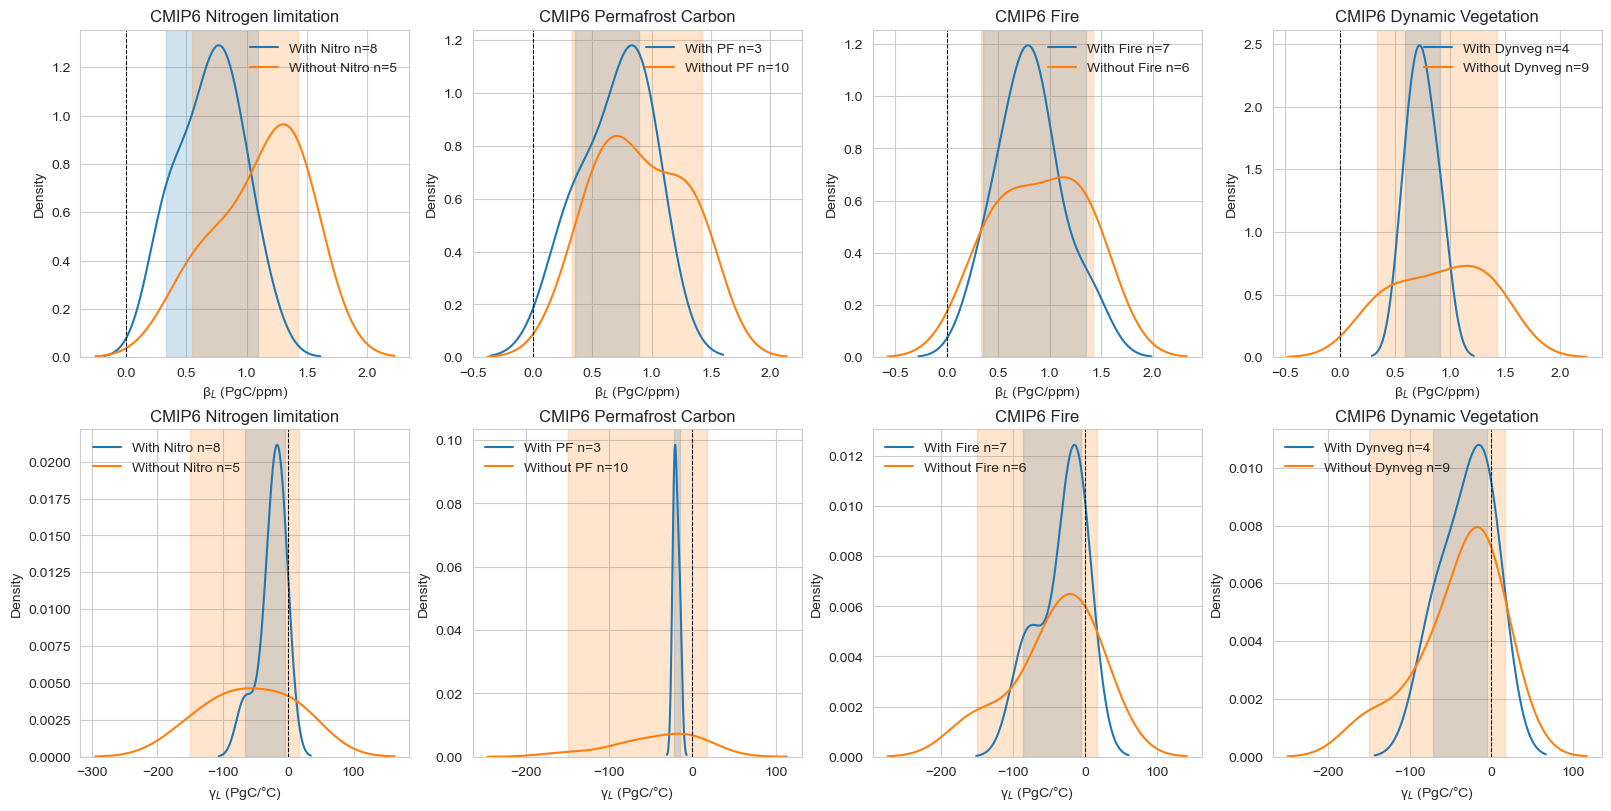

In [151]:
# sanity check

fig = plt.figure(figsize=(16,8), layout="constrained")

sub = fig.add_subplot(2, 4, 1)
sub.set_title('CMIP6 Nitrogen limitation')
sub.set_xlabel('β${_L}$ (PgC/ppm)')
sns.kdeplot(evidence_CMIP6['beta_land'][cmip6_hasNitro],label="With Nitro n="+str(len(evidence_CMIP6['beta_land'][cmip6_hasNitro])))
sns.kdeplot(evidence_CMIP6['beta_land'][~cmip6_hasNitro],label="Without Nitro n="+str(len(evidence_CMIP6['beta_land'][~cmip6_hasNitro])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['beta_land'][cmip6_hasNitro]), max(evidence_CMIP6['beta_land'][cmip6_hasNitro]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['beta_land'][~cmip6_hasNitro]), max(evidence_CMIP6['beta_land'][~cmip6_hasNitro]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper right')

sub = fig.add_subplot(2, 4, 2)
sub.set_title('CMIP6 Permafrost Carbon')
sub.set_xlabel('β${_L}$ (PgC/ppm)')
sns.kdeplot(evidence_CMIP6['beta_land'][cmip6_hasPF],label="With PF n="+str(len(evidence_CMIP6['beta_land'][cmip6_hasPF])))
sns.kdeplot(evidence_CMIP6['beta_land'][~cmip6_hasPF],label="Without PF n="+str(len(evidence_CMIP6['beta_land'][~cmip6_hasPF])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['beta_land'][cmip6_hasPF]), max(evidence_CMIP6['beta_land'][cmip6_hasPF]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['beta_land'][~cmip6_hasPF]), max(evidence_CMIP6['beta_land'][~cmip6_hasPF]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper right')

sub = fig.add_subplot(2, 4, 3)
sub.set_title('CMIP6 Fire')
sub.set_xlabel('β${_L}$ (PgC/ppm)')
sns.kdeplot(evidence_CMIP6['beta_land'][cmip6_hasFire],label="With Fire n="+str(len(evidence_CMIP6['beta_land'][cmip6_hasFire])))
sns.kdeplot(evidence_CMIP6['beta_land'][~cmip6_hasFire],label="Without Fire n="+str(len(evidence_CMIP6['beta_land'][~cmip6_hasFire])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['beta_land'][cmip6_hasFire]), max(evidence_CMIP6['beta_land'][cmip6_hasFire]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['beta_land'][~cmip6_hasFire]), max(evidence_CMIP6['beta_land'][~cmip6_hasFire]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper right')

sub = fig.add_subplot(2, 4, 4)
sub.set_title('CMIP6 Dynamic Vegetation')
sub.set_xlabel('β${_L}$ (PgC/ppm)')
sns.kdeplot(evidence_CMIP6['beta_land'][cmip6_hasDynveg],label="With Dynveg n="+str(len(evidence_CMIP6['beta_land'][cmip6_hasDynveg])))
sns.kdeplot(evidence_CMIP6['beta_land'][~cmip6_hasDynveg],label="Without Dynveg n="+str(len(evidence_CMIP6['beta_land'][~cmip6_hasDynveg])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['beta_land'][cmip6_hasDynveg]), max(evidence_CMIP6['beta_land'][cmip6_hasDynveg]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['beta_land'][~cmip6_hasDynveg]), max(evidence_CMIP6['beta_land'][~cmip6_hasDynveg]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper right')

sub = fig.add_subplot(2, 4, 5)
sub.set_title('CMIP6 Nitrogen limitation')
sub.set_xlabel('γ${_L}$ (PgC/°C)')
sns.kdeplot(evidence_CMIP6['gamma_land'][cmip6_hasNitro],label="With Nitro n="+str(len(evidence_CMIP6['gamma_land'][cmip6_hasNitro])))
sns.kdeplot(evidence_CMIP6['gamma_land'][~cmip6_hasNitro],label="Without Nitro n="+str(len(evidence_CMIP6['gamma_land'][~cmip6_hasNitro])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['gamma_land'][cmip6_hasNitro]), max(evidence_CMIP6['gamma_land'][cmip6_hasNitro]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['gamma_land'][~cmip6_hasNitro]), max(evidence_CMIP6['gamma_land'][~cmip6_hasNitro]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper left')

sub = fig.add_subplot(2, 4, 6)
sub.set_title('CMIP6 Permafrost Carbon')
sub.set_xlabel('γ${_L}$ (PgC/°C)')
sns.kdeplot(evidence_CMIP6['gamma_land'][cmip6_hasPF],label="With PF n="+str(len(evidence_CMIP6['gamma_land'][cmip6_hasPF])))
sns.kdeplot(evidence_CMIP6['gamma_land'][~cmip6_hasPF],label="Without PF n="+str(len(evidence_CMIP6['gamma_land'][~cmip6_hasPF])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['gamma_land'][cmip6_hasPF]), max(evidence_CMIP6['gamma_land'][cmip6_hasPF]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['gamma_land'][~cmip6_hasPF]), max(evidence_CMIP6['gamma_land'][~cmip6_hasPF]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper left')

sub = fig.add_subplot(2, 4, 7)
sub.set_title('CMIP6 Fire')
sub.set_xlabel('γ${_L}$ (PgC/°C)')
sns.kdeplot(evidence_CMIP6['gamma_land'][cmip6_hasFire],label="With Fire n="+str(len(evidence_CMIP6['gamma_land'][cmip6_hasFire])))
sns.kdeplot(evidence_CMIP6['gamma_land'][~cmip6_hasFire],label="Without Fire n="+str(len(evidence_CMIP6['gamma_land'][~cmip6_hasFire])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['gamma_land'][cmip6_hasFire]), max(evidence_CMIP6['gamma_land'][cmip6_hasFire]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['gamma_land'][~cmip6_hasFire]), max(evidence_CMIP6['gamma_land'][~cmip6_hasFire]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper left')

sub = fig.add_subplot(2, 4, 8)
sub.set_title('CMIP6 Dynamic Vegetation')
sub.set_xlabel('γ${_L}$ (PgC/°C)')
sns.kdeplot(evidence_CMIP6['gamma_land'][cmip6_hasDynveg],label="With Dynveg n="+str(len(evidence_CMIP6['gamma_land'][cmip6_hasDynveg])))
sns.kdeplot(evidence_CMIP6['gamma_land'][~cmip6_hasDynveg],label="Without Dynveg n="+str(len(evidence_CMIP6['gamma_land'][~cmip6_hasDynveg])))
sub.axvline(0, color='k', linestyle='--', lw=0.75)
sub.axvspan(min(evidence_CMIP6['gamma_land'][cmip6_hasDynveg]), max(evidence_CMIP6['gamma_land'][cmip6_hasDynveg]), color='tab:blue', alpha=0.2)
sub.axvspan(min(evidence_CMIP6['gamma_land'][~cmip6_hasDynveg]), max(evidence_CMIP6['gamma_land'][~cmip6_hasDynveg]), color='tab:orange', alpha=0.2)
sub.legend(frameon=False, loc='upper left')


###  Emergent constraints
Read in the emergent constraint data from Zechlau et al 2022

In [152]:
with pdfplumber.open("DATA/Zechlau2022.pdf") as pdf:
    page = pdf.pages[6]
    zechtable = page.extract_table()

title=" ".join([x.split("\n") for x in zechtable[0]][0])
rawcolumns=zechtable[1][0].split(" ")
columns=["Model", "γ_LT", "σ_LT", 'γ_IAV', "σ_IAV"]
zdata=zechtable[2:][0][0].split()
ncol=len(columns)

cmip5_list = [item for item in zdata[1:zdata.index("CMIP6")] if item != '±']
L=len(cmip5_list)

nrows=int(L/ncol)
cmip5_gammas=pd.DataFrame(np.array(cmip5_list).reshape((nrows,ncol)),columns=columns)

cmip6_list = [item for item in zdata[zdata.index("CMIP6")+1:zdata.index("OBS")] if item != '±']
cmip6_list
L6=len(cmip6_list)
rows6=int(L6/ncol)
cmip6_strings=np.array(cmip6_list).reshape((rows6,ncol))
cmip6_gammas=pd.DataFrame(cmip6_strings,columns=columns)


# now need to do some more data cleaning :(
mystr=cmip6_gammas["γ_LT"].values[0]
# For some reason it can't read the minus sign from the pdf- replace by hand
badval=mystr[0]


for c in columns[1:]:
    try:
        cmip6_gammas[c]=pd.to_numeric(cmip6_gammas[c])
    except:
        
        cmip6_gammas[c]=[float(x.replace(badval,"-")) for x in cmip6_gammas[c]]

In [153]:
evidence_EC = {"γ_LT":cmip6_gammas.γ_LT.values,\
            "γ_IAV":cmip6_gammas.γ_IAV.values,\
            "σ_LT":cmip6_gammas.σ_LT.values,\
            "σ_IAV":cmip6_gammas.σ_IAV.values,\
            "IAV_observed_mean":-4.3,\
            "IAV_observed_std": 0.67 }

We could just calculate the sample mean and standard deviation of the ensemble and report the 95% uncertainty level as $\pm 1.96 \times \sigma$.  This is kind of silly, though, because models aren't independent, and the spread might misrepresent true uncertainty.  There's no explicit modeling of clustering or multimodality in the CMIP6 results.  And it's not very Bayesian- it doesn't allow us to learn from additional data or identify any emergent patterns.

## --> Random-effects model (@Kate)
Or we can just assume that each model gives us a $x^i$ that differs from the ``true" $X$ by some bias:
$$x^i \sim N(X-B_i,\sigma_i^2)$$
with the biases distributed as 
$$B_i \sim N(0,\tau^2)$$
If we don't care about the posteriors for each individual bias term $B_i$ we can marginalize over them:
$$P(x_i | X) = \int P(x_i | X,B_i) P(B_i) dB_i.$$
Since everything is Gaussian the integral has an analytic solution and 
$$x^i \sim N(X,\sigma_i^2+\tau^2)$$

# Estimating $\beta_L$
## Inclusion of processes
Some CMIP6 models have explicit representation of processes that affect $\beta$ and $\gamma$ while others do not.  For example, roughly half the CMIP6 models represent the N cycle.  

We want to get information about $\beta$ from all the models- we don't just want to throw away the results from the models without a nitrogen cycle!  This means we need a model for how including the N cycle might modify the estimate of $\beta$.  Let's try a multiplicative model, where including this process modifies the total: $\beta = \eta b$.

Every result from the CMIP6 models tells us about $b$, but only the models with nitrogen cycles can tell us about $\eta$.  I assume there's an intrinsic CMIP model spread (estimated from all models) in $b$ (denoted $\sigma_b$) and a model spread in the scaling factor $\sigma_{\eta}$ (estimated only from the models with a nitrogen cycle.). The standard deviation of the product $\eta b$ is assumed to be $\sigma_{\eta b} = \sqrt{\bar{\eta}^2 \sigma_{b}^2 + \bar{b}^2 \sigma_{\eta}^2 + \sigma_{\eta}^2 \sigma_{b}^2}$

### N limitation

In [154]:
# eta is a guess from ACCESS and UKESM ensemble runs (@ Chris J.), and can be updated when more data is available
# from 4xCO2
eta_nlim_access= beta_4xCO2[TCREsource_betagamma['model'].isin(['ACCESS-ESM_CN'])]/beta_4xCO2[TCREsource_betagamma['model'].isin(['ACCESS-ESM_C'])] #0.69 
eta_nlim_ukesm= beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_ctrl'])]/beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_nonlim'])] #0.77

eta_proc = [eta_nlim_access,eta_nlim_ukesm]
print(eta_proc)

[array([0.73899594]), array([0.60652826])]


In [155]:
with pm.Model() as beta_land_model:
    
    # η prior, informed by observations
    #PRIOR
    eta = pm.Uniform("eta", 0,1)
    # Variance of eta
    #PRIOR
    sigma_eta = pm.HalfNormal("sigma_eta",0.1)  
    # Learn the true value of η and its uncertainty from the published estimates 
    eta_obs=pm.Normal("eta_obs", mu=eta, sigma=sigma_eta, observed=eta_proc)

    # mean of unscaled CO2 effect 
    #PRIOR
    #IT WILL BE SENSITIVE TO THIS
    βL=pm.Normal("βL",0,100)

    # Structural spread of models with no nitrogen cycle
    #PRIOR
    tau_B = pm.HalfNormal("tau_B", sigma=0.05)
    
   
    mu_B = pm.Deterministic("mu_B", βL/eta)


    # Derived standard deviation for β models
    tau_beta_sq =  eta**2 * tau_B**2 + mu_B**2 * sigma_eta**2
    tau_beta = pm.Deterministic("tau_beta", pm.math.sqrt(tau_beta_sq))
    
    #Internal variability: REPLACE IF WE GET MODEL ESTIMATES
    #IT'S VERY SENSITIVE TO THIS
    sigma_b=np.sqrt(evidence_CMIP6['beta_land'][~cmip6_hasNitro]) #.1 #np.sqrt(evidence['βL_without_N'])
    sigma_beta = np.sqrt(evidence_CMIP6['beta_land'][cmip6_hasNitro]) #.1  #np.sqrt(evidence['βL_including_N'])
    
    # Likelihoods
    B_obs = pm.Normal("B_obs", mu=mu_B, sigma=pm.math.sqrt(tau_B**2+sigma_b**2), observed=evidence_CMIP6['beta_land'][~cmip6_hasNitro])
    beta_obs = pm.Normal("beta_obs", mu=βL, sigma=pm.math.sqrt(tau_beta**2+sigma_beta**2), observed=evidence_CMIP6['beta_land'][cmip6_hasNitro])

    # Posterior sampling
    beta_land_trace_Nlim = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_eta, βL, tau_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Text(0.5, 1.0, 'β${_L}$ N limitation')

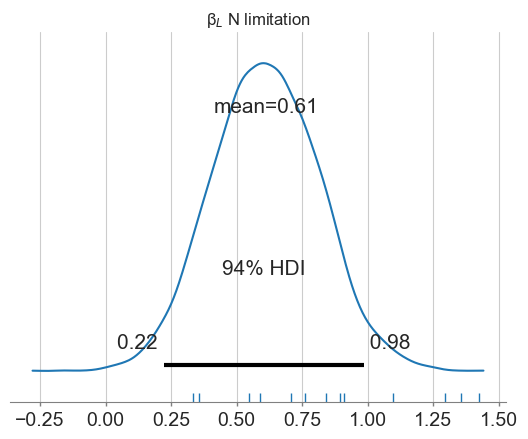

In [156]:
az.plot_posterior(beta_land_trace_Nlim,var_names=["βL"])
sns.rugplot(evidence_CMIP6['beta_land'])
plt.title('β${_L}$ N limitation')

### Permafrost

In [157]:
# We currently don't have a run that isolated permafrost (eventually UViC should provide that)
# However, beta change due to permaforst is expected to be ~0, so we set it to eta to 1.0 here
eta_pf= 1.0

eta_proc = [eta_pf]
print(eta_proc)

[1.0]


In [158]:
with pm.Model() as beta_land_model:
    
    # η prior, informed by observations
    #PRIOR
    eta = pm.Uniform("eta", 0,1)
    # Variance of eta
    #PRIOR
    sigma_eta = pm.HalfNormal("sigma_eta",0.1)  
    # Learn the true value of η and its uncertainty from the published estimates 
    eta_obs=pm.Normal("eta_obs", mu=eta, sigma=sigma_eta, observed=eta_proc)

    # mean of unscaled CO2 effect 
    #PRIOR
    #IT WILL BE SENSITIVE TO THIS
    βL=pm.Normal("βL",0,100)

    # Structural spread of models with no process X
    #PRIOR
    tau_B = pm.HalfNormal("tau_B", sigma=0.05)
    
   
    mu_B = pm.Deterministic("mu_B", βL/eta)


    # Derived standard deviation for β models
    tau_beta_sq =  eta**2 * tau_B**2 + mu_B**2 * sigma_eta**2
    tau_beta = pm.Deterministic("tau_beta", pm.math.sqrt(tau_beta_sq))
    
    #Internal variability: REPLACE IF WE GET MODEL ESTIMATES
    #IT'S VERY SENSITIVE TO THIS
    sigma_b=np.sqrt(evidence_CMIP6['beta_land'][~cmip6_hasPF]) #.1 #np.sqrt(evidence['βL_without_N'])
    sigma_beta = np.sqrt(evidence_CMIP6['beta_land'][cmip6_hasPF]) #.1  #np.sqrt(evidence['βL_including_N'])
    
    # Likelihoods
    B_obs = pm.Normal("B_obs", mu=mu_B, sigma=pm.math.sqrt(tau_B**2+sigma_b**2), observed=evidence_CMIP6['beta_land'][~cmip6_hasPF])
    beta_obs = pm.Normal("beta_obs", mu=βL, sigma=pm.math.sqrt(tau_beta**2+sigma_beta**2), observed=evidence_CMIP6['beta_land'][cmip6_hasPF])

    # Posterior sampling
    beta_land_trace_pf = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_eta, βL, tau_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Text(0.5, 1.0, 'β${_L}$ Permafrost')

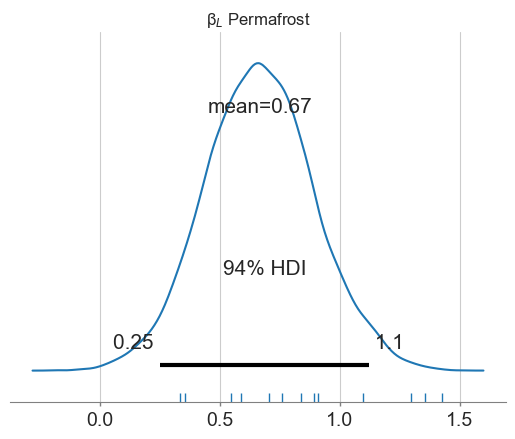

In [159]:
az.plot_posterior(beta_land_trace_pf,var_names=["βL"])
sns.rugplot(evidence_CMIP6['beta_land'])
plt.title('β${_L}$ Permafrost')

### Fire

In [160]:
# from 4xCO2
eta_fire_ukesm= beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_fire'])]/beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_ctrl'])]

eta_proc = [eta_fire_ukesm]
print(eta_proc)

[array([0.76179081])]


In [161]:
with pm.Model() as beta_land_model:
    
    # η prior, informed by observations
    #PRIOR
    eta = pm.Uniform("eta", 0,1)
    # Variance of eta
    #PRIOR
    sigma_eta = pm.HalfNormal("sigma_eta",0.1)  
    # Learn the true value of η and its uncertainty from the published estimates 
    eta_obs=pm.Normal("eta_obs", mu=eta, sigma=sigma_eta, observed=eta_proc)

    # mean of unscaled CO2 effect 
    #PRIOR
    #IT WILL BE SENSITIVE TO THIS
    βL=pm.Normal("βL",0,100)

    # Structural spread of models with no process X
    #PRIOR
    tau_B = pm.HalfNormal("tau_B", sigma=0.05)
    
   
    mu_B = pm.Deterministic("mu_B", βL/eta)


    # Derived standard deviation for β models
    tau_beta_sq =  eta**2 * tau_B**2 + mu_B**2 * sigma_eta**2
    tau_beta = pm.Deterministic("tau_beta", pm.math.sqrt(tau_beta_sq))
    
    #Internal variability: REPLACE IF WE GET MODEL ESTIMATES
    #IT'S VERY SENSITIVE TO THIS
    sigma_b=np.sqrt(evidence_CMIP6['beta_land'][~cmip6_hasFire]) #.1 #np.sqrt(evidence['βL_without_N'])
    sigma_beta = np.sqrt(evidence_CMIP6['beta_land'][cmip6_hasFire]) #.1  #np.sqrt(evidence['βL_including_N'])
    
    # Likelihoods
    B_obs = pm.Normal("B_obs", mu=mu_B, sigma=pm.math.sqrt(tau_B**2+sigma_b**2), observed=evidence_CMIP6['beta_land'][~cmip6_hasFire])
    beta_obs = pm.Normal("beta_obs", mu=βL, sigma=pm.math.sqrt(tau_beta**2+sigma_beta**2), observed=evidence_CMIP6['beta_land'][cmip6_hasFire])

    # Posterior sampling
    beta_land_trace_fire = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_eta, βL, tau_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 945 divergences after tuning. Increase `target_accept` or reparameterize.


Text(0.5, 1.0, 'β${_L}$ Fire')

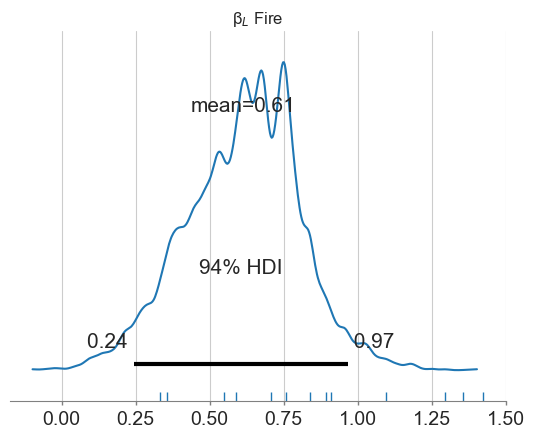

In [162]:
az.plot_posterior(beta_land_trace_fire,var_names=["βL"])
sns.rugplot(evidence_CMIP6['beta_land'])
plt.title('β${_L}$ Fire')

### Dynamic Vegetation

In [163]:
# from 4xCO2
eta_dynveg_ukesm= beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_ctrl'])]/beta_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_nodgvm'])]

eta_proc = [eta_dynveg_ukesm]
print(eta_proc)

[array([1.28532461])]


In [164]:
with pm.Model() as beta_land_model:
    
    # η prior, informed by observations
    #PRIOR
    eta = pm.Uniform("eta", 0,1)
    # Variance of eta
    #PRIOR
    sigma_eta = pm.HalfNormal("sigma_eta",0.1)  
    # Learn the true value of η and its uncertainty from the published estimates 
    eta_obs=pm.Normal("eta_obs", mu=eta, sigma=sigma_eta, observed=eta_proc)

    # mean of unscaled CO2 effect 
    #PRIOR
    #IT WILL BE SENSITIVE TO THIS
    βL=pm.Normal("βL",0,100)

    # Structural spread of models with no process X
    #PRIOR
    tau_B = pm.HalfNormal("tau_B", sigma=0.05)
    
   
    mu_B = pm.Deterministic("mu_B", βL/eta)


    # Derived standard deviation for β models
    tau_beta_sq =  eta**2 * tau_B**2 + mu_B**2 * sigma_eta**2
    tau_beta = pm.Deterministic("tau_beta", pm.math.sqrt(tau_beta_sq))
    
    #Internal variability: REPLACE IF WE GET MODEL ESTIMATES
    #IT'S VERY SENSITIVE TO THIS
    sigma_b=np.sqrt(evidence_CMIP6['beta_land'][~cmip6_hasDynveg]) #.1 #np.sqrt(evidence['βL_without_N'])
    sigma_beta = np.sqrt(evidence_CMIP6['beta_land'][cmip6_hasDynveg]) #.1  #np.sqrt(evidence['βL_including_N'])
    
    # Likelihoods
    B_obs = pm.Normal("B_obs", mu=mu_B, sigma=pm.math.sqrt(tau_B**2+sigma_b**2), observed=evidence_CMIP6['beta_land'][~cmip6_hasDynveg])
    beta_obs = pm.Normal("beta_obs", mu=βL, sigma=pm.math.sqrt(tau_beta**2+sigma_beta**2), observed=evidence_CMIP6['beta_land'][cmip6_hasDynveg])

    # Posterior sampling
    beta_land_trace_dynveg = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_eta, βL, tau_B]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


Text(0.5, 1.0, 'β${_L}$ Dynveg')

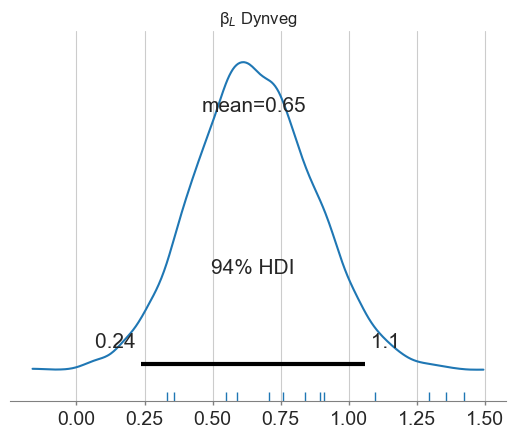

In [165]:
az.plot_posterior(beta_land_trace_dynveg,var_names=["βL"])
sns.rugplot(evidence_CMIP6['beta_land'])
plt.title('β${_L}$ Dynveg')

# Estimating $\gamma_L$ 
We assume that the nitrogen cycle scaling parameter is $\nu$
## Modeling the emergent constraint
We model IAV as linear in $\gamma_L$: 
$$IAV = m \gamma_L + b + \epsilon$$
where $\epsilon \sim N(0,\sigma)$ is the noise.  In Bayesian linear regression, this is expressed as a conditional distribution:
$$ IAV | \gamma_L \sim N(m \gamma_L+b,\sigma)$$
There are three hyperparameters: the slope of the line $m$, the intercept $b$, and the noise $\sigma$.  Note that the choice of model for the emergent constraint (here it's linear) determines the parameters $\Theta = (m,b,\sigma)$.  We'll use priors $m,b \sim N(0,10)$ and $\sigma \sim N^{+}(10)$.  You could allow users to specify these priors -- this would probably make sense for cases in which the relationship between the observable quantity and the thing to be esimated is less clear-- but here the functional form is pretty obviously linear and it won't really matter which priors we use.

In [166]:
# Note that we put priors on negative gamma so gamma can be made negative definite if desired
priors = {
    'neg_gamma_LT': lambda name: pm.Normal(name,0,100),#lambda name: pm.LogNormal(name, mu=np.log(50), sigma=1),
    'nu': lambda name: pm.Uniform(name, 0,1),\
    'neg_gamma_LX': lambda name: pm.Normal(name,0,100)
    
}

hyperpriors={
        'm': lambda name: pm.Normal(name,0,10),
        'b': lambda name: pm.Normal(name,0,10),
        'sigma_nu' : lambda name: pm.HalfNormal(name,0.1) ,\
        'tau_G' : lambda name: pm.HalfNormal(name, sigma=np.std(evidence_CMIP6["gamma_land"]))
    
}

### N limitation

In [167]:
# from 4xCO2
nu_nlim_access= gamma_4xCO2[TCREsource_betagamma['model'].isin(['ACCESS-ESM_CN'])]/gamma_4xCO2[TCREsource_betagamma['model'].isin(['ACCESS-ESM_C'])]
nu_nlim_ukesm= gamma_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_ctrl'])]/gamma_4xCO2[TCREsource_betagamma['model'].isin(['UKESM1-1_nodgvm'])]

nu_proc = [nu_nlim_access, nu_nlim_ukesm]
print(nu_proc)

[array([0.76579555]), array([0.92653976])]


In [169]:
with pm.Model() as random_effects_model_gamma:

    # Variance of nu
    #HYPERPRIOR
    sigma_nu = hyperpriors["sigma_nu"](name="sigma_nu") 
    # nu prior, informed by observations
    #PRIOR on scaling from nitrogen inclusion
    nu = priors["nu"](name="nu")
    # Learn the true value of nu and its uncertainty from the published estimates 
    nu_obs=pm.Normal("nu_obs", mu=nu, sigma=sigma_nu, observed=nu_proc)
    
    # PRIORS ON TROPICAL AND EXTRATROPICAL GAMMA
    γLX = pm.Deterministic("γLX",priors["neg_gamma_LX"](name='neg_gamma_LX')*-1)
    γLT = pm.Deterministic("γLT",priors["neg_gamma_LT"](name='neg_gamma_LT')*-1)
    γL= pm.Deterministic("γL",γLX + γLT)

    #IF WE WANT TO WE CAN ADD A GAMMA_PERMAFROST TERM HERE
    # DO WE HAVE ANY EVIDENCE?

    ### EMERGENT CONSTRAINT ###
    # EMERGENT CONSTRAINT ON TROPICAL γLT
    n_models_EC=len(evidence_EC['γ_LT'])
        #Assume linear relationships
    m = hyperpriors["m"](name="m")
    b = hyperpriors["b"](name="b")

    # Latent true x values
    x_true = pm.Normal("x_true", mu=evidence_EC['γ_LT'], \
                       sigma=evidence_EC['σ_LT'], \
                       shape=n_models_EC)
    
    # Linear model for true IAV values
    y_true = m * x_true + b

    # Likelihood of observed IAV values
    y_likelihood = pm.Normal("y_obs", mu=y_true, \
                             sigma=evidence_EC['σ_IAV'],\
                             shape=n_models_EC,\
                             observed=evidence_EC['γ_IAV'])
    #Emergent constraint relationship
   
    mu_obs = m * γLT + b
    # IAV observed ~ N(-4.3,0.67) #CHECK IF THIS IS ONE OR TWO SIGMA
    IAV_true=pm.Normal("IAV_true",mu=mu_obs,\
                       sigma=evidence_EC["IAV_observed_std"],\
                       observed = [evidence_EC["IAV_observed_mean"]])
    
    # UNSCALED VALUE
    mu_G = γL/nu

    # Structural spread of models with no nitrogen cycle
    #HYPERPRIOR
    tau_G = hyperpriors["tau_G"](name="tau_G")
    
    
    # Derived standard deviation for  models
    tau_gamma_sq =  nu**2 * tau_G**2 + mu_G**2 * sigma_nu**2
    tau_gamma = pm.Deterministic("tau_gamma", pm.math.sqrt(tau_gamma_sq))

    # internal variability terms
    #REPLACE WITH MODEL-BASED ESTIMATES
    sigma_gamma = np.std(evidence_CMIP6['gamma_land'][~cmip6_hasNitro]) #.1
    sigma_G = np.std(evidence_CMIP6['gamma_land'][cmip6_hasNitro]) #.1
    
    
    
    # Likelihoods
    G_obs = pm.Normal("G_obs", mu=mu_G, sigma=pm.math.sqrt(tau_G**2+sigma_G**2), observed=evidence_CMIP6['gamma_land'][cmip6_hasNitro])
    gamma_obs = pm.Normal("gamma_obs", mu=γL, sigma=pm.math.sqrt(tau_gamma**2+sigma_gamma**2), observed=evidence_CMIP6['gamma_land'][~cmip6_hasNitro])

    # Posterior sampling
    random_effects_trace_gamma = pm.sample(target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_nu, nu, neg_gamma_LX, neg_gamma_LT, m, b, x_true, tau_G]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


Text(0.5, 1.0, 'γ${_L}$ N limitation')

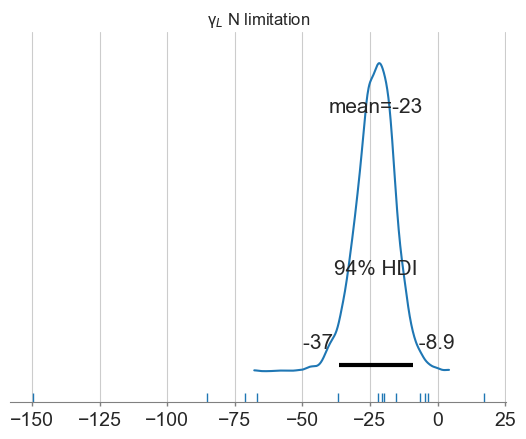

In [173]:
az.plot_posterior(random_effects_trace_gamma,var_names=["γL"])
sns.rugplot(evidence_CMIP6['gamma_land'])
plt.title('γ${_L}$ N limitation')